# Rethinking Stuff-based Pitch Models

### Introduction

One way to construct a pitch model is to predict the effectiveness of a pitch based solely on its' "stuff" (velocity, break, and release point) while excluding information about pitch's location and count. This separates the characteristics that are inherent to the pitch from those that can vary widely from pitch to pitch, resulting in more stable aggregate predictions with fewer pitches. Additionally, a pitcher's stuff is typically harder to change than their usage by count and location, so stuff is more important when evaluating a pitcher's potential.

The most obvious and straightforward way to accomplish this is to build a model whose features solely depend on the pitch's velocity, break, and release point. However, this still leaks information about the count and location of the pitch into the model! Because count and location are more important than stuff in determining the outcome of any single pitch, a model will  effectively infer the distribution of counts and locations empirically from similar pitches. This may not sound like a problem but it presents three issues:

1. These inferred distributions are unknown, making the model less explainable. It also potentially introduces an unknown source of bias if the distributions are more precise for some types of pitches than others.
2. It introduces a selection bias effect into the model. If the model is built on MLB data (which makes sense, since we really only care about how a pitch will perform against MLB hitters), then we only see pitches from pitchers good enough to make the major leagues. For example, very few MLB pitchers have an 87 MPH fastball unless they have exceptional command (e.g. Kyle Hendricks). The model will learn that worse pitches tend to be located better, because if they weren't, then the pitcher wouldn't be in MLB. This artificially compresses the low-end of the model's predictions.
3. Models will be much less accurate if they don't include the most predictive features.

Therefore, I propose building a stuff-based pitch model that explicitly defines usage distributions over count and location.

### Setting up the data
First I import the necessary libraries and set some options.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict
import operator
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import warnings

pd.set_option('display.max_rows', 100)
warnings.simplefilter(action='ignore', category=FutureWarning)

For this project, I downloaded all of the pitch by pitch data from the 2020 MLB Regular Season from Baseball Savant in 8 files. Here I load this data, select the relevant columns to keep, exclude bunt attempts, and parse the `description` column into the result of each pitch. I also calculate a more precise release speed from the intial velocity components, adjust the acceleration in the z-direction for gravity, and flip the release position and acceleration in the x-direction for left-handed pitchers.

The break data provided by Baseball Savant only includes vertical and horizontal break to the nearest 0.1 feet, so I elected to use the acceleration of the pitch in the x- and z- directions instead, which were listed to higher precision. This should be almost entirely from the Magnus force induced by the spin of the baseball, although there may be a small drag component that leaks in as well since the pitch doesn't travel exactly in the y-direction, not to mention the possibility of a seam shifted wake recently investigated by Barton Smith. I excluded extension because its currently problematic with the new Hawkeye tracking system.

In [2]:
df = pd.DataFrame()
df = pd.concat([df, pd.read_csv('savant_data.csv')])

for i in range(7):
    df = pd.concat([df, pd.read_csv(f'savant_data ({i+1}).csv')])

cols = ['pitch_type', 'release_pos_x', 'release_pos_z', 'player_name', 'pitcher', 'description', 'stand', 'p_throws', 
        'balls', 'strikes', 'plate_x', 'plate_z', 'vx0', 'vy0', 'vz0', 'ax', 'az', 'estimated_woba_using_speedangle']

df = df.loc[~df.description.isin(['foul_bunt', 'missed_bunt', 'pitchout', 'bunt_foul_tip'])].copy()
df = df.loc[~df.events.isin(['interf_def', 'sac_bunt'])].copy()
df = df[cols].copy()
df = df.rename(columns={'estimated_woba_using_speedangle':'woba'})

df['pitch'] = 1
df['swing'] = np.where(df.description.isin(['foul', 'hit_into_play', 'swinging_strike', 'hit_into_play_no_out', 
                                            'hit_into_play_score', 'foul_tip', 'swinging_strike_blocked']), 1, 0)
df['swstr'] = np.where(df.description.isin(['swinging_strike', 'foul_tip', 'swinging_strike_blocked']), 1, 0)
df['contact'] = df.swing-df.swstr
df['foul'] = np.where(df.description == 'foul', 1, 0)
df['inplay'] = df.contact-df.foul
df['noswing'] = 1 - df.swing
df['callstr'] = np.where(df.description == 'called_strike', 1, 0)
df['ball'] = df.noswing-df.callstr

df['release_speed'] = np.sqrt(np.square(df.vx0)+np.square(df.vy0)+np.square(df.vz0))
df['az'] += 32.174
df['ax'] = np.where(df.p_throws == 'L', -df.ax, df.ax)
df['release_pos_x'] = np.where(df.p_throws == 'L', -df.release_pos_x, df.release_pos_x)
df['plate_dist'] = np.sqrt(np.square(df.plate_x) + np.square(df.plate_z-2.5))

### Clustering the Data
How are we going to define the distributions over count and location? By clustering the data, and assigning each pitch in each cluster the distribution of the cluster as a whole. Implemented correctly, pitches with similar intents will be clustered together.

In addition to velocity, break, and release point, there is one additional piece of information that is helpful for both pitch clustering and the pitch model itself: a pitch's offset from the pitcher's average fastball characteristics. For clustering, it is necessary in order to distinguish hard changeups from slow sinkers, and to a lesser extent hard sliders from slow cutters. For the overall pitch models, it is valid to include because for a given pitcher, the offset is as "inherent" as the pitch attributes themselves. The offset helps contextualize how a batter might react differently to pitchers with different fastball shapes and velocities, even when they are throwing breaking or offspeed pitches. In this way, it is more helpful to think of each non-fastball pitch a pitcher throws as working in tandem with the pitcher's fastball for the purposes of the model's evaluation. For fastballs, the offset from the average fastball is set to 0.

In [3]:
fa = df.loc[df.pitch_type.isin(['FF', 'SI']), ['pitcher', 'release_speed', 'ax', 'az']].groupby('pitcher').mean()

df = df.merge(fa, on='pitcher', suffixes=('', '_fa'))

df['release_speed_fa'] -= df.release_speed
df['ax_fa'] -= df.ax
df['az_fa'] -= df.az
df['release_speed_fa'] = np.where(df.pitch_type.isin(['FF', 'SI']), 0, df.release_speed_fa)
df['ax_fa'] = np.where(df.pitch_type.isin(['FF', 'SI']), 0, df.ax_fa)
df['az_fa'] = np.where(df.pitch_type.isin(['FF', 'SI']), 0, df.az_fa)

For clustering, the relative weight of each dimension is important. While I could use techniques such as PCA, for problems like this where the features have distinct physical meanings and there is a specific objective, I have devised a way to use XGBoost feature importance to set the dimension weights.
1. Roughly tune the parameters of an XGBoost model to predict your objective, or something closely related to it. In this case, I chose swinging strike rate.
2. Using the `total_gain` importance type for each feature, normalize the importance relative to the most important feature.
3. Normalize each of the features to have mean 0 and variance 1, and then multiply by the normalized feature importance.
4. Perform clustering. In this case I chose k-means clustering with 16 clusters.

It is important to note that because the x component of the acceleration and release point were flipped for left-handed pitchers, they can be included in the same clustering process as the right-handed pitchers without creating separate clusters for the same pitch thrown from the opposite side.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   22.5s finished


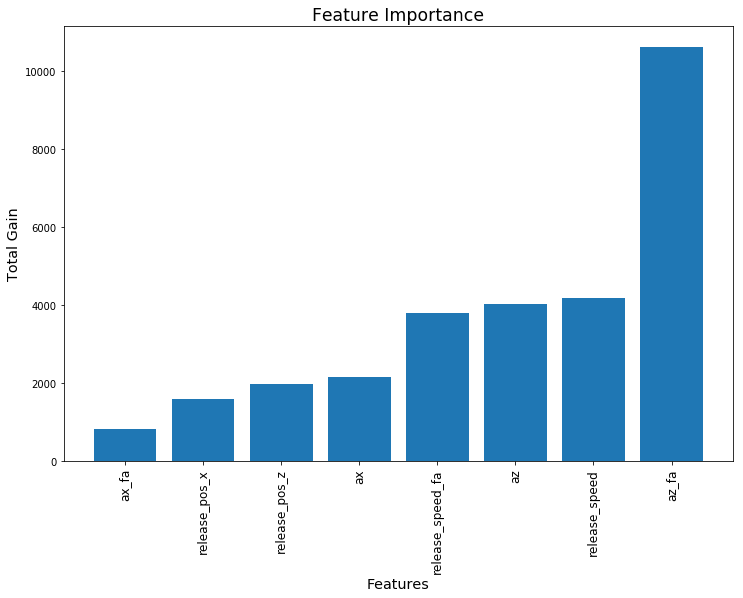

In [4]:
predictors = ['release_speed', 'release_speed_fa', 'release_pos_x', 'release_pos_z', 'ax', 'az', 'ax_fa', 'az_fa']

df = df.dropna(subset=predictors).copy()

target = 'swstr'

xgb_temp = XGBClassifier(
 learning_rate = 0.1,
 n_estimators=110,
 max_depth=7,
 min_child_weight=128,
 gamma=1,
 subsample=1,
 colsample_bytree=1,
 reg_alpha=0.5,
 reg_lambda=0.2,
 objective= 'binary:logistic',
 nthread=1,
 scale_pos_weight=1,
 seed=42)

param_grid = {
    'min_child_weight': [256], 'gamma': [0.5], 'max_depth':[6]
}

clf = GridSearchCV(xgb_temp, param_grid, scoring='neg_log_loss', cv=5, n_jobs=10, return_train_score = True, verbose = 2)

clf.fit(df[predictors], df[target])

f = clf.best_estimator_.get_booster().get_score(importance_type = 'total_gain')
sorted_f = sorted(f.items(), key=operator.itemgetter(1))
x, y = zip(*sorted_f)
plt.figure(figsize=(12,8))
plt.bar(x,y)
plt.xticks(x, rotation='vertical',size='large')
plt.xlabel('Features', size='x-large')
plt.ylabel('Total Gain', size='x-large')
plt.title('Feature Importance', size='xx-large')
plt.show()

max_val = max(f.values())
for key in f:
    f[key] /= max_val
    f[key] = np.sqrt(f[key])

means = {}
stds = {}
for col in predictors:
    means[col] = np.mean(df[col])
    stds[col] = np.std(df[col])
    df[col] = f[col]*(df[col]-means[col])/stds[col]

kmeans = KMeans(n_clusters=16, random_state=42).fit(df[predictors])

df['cluster'] = kmeans.labels_

### Exploring the Clusters
Let's take a quick detour to explore the clusters and make sure they accomplish our goal of separating the pitches by function and intent. First let's look at which pitch types, as determined by baseball savant, are most common in each cluster.

In [5]:
cp = pd.DataFrame(df.groupby(by=['cluster', 'pitch_type']).count()['release_speed'])
cp.columns = ['N']
cp = cp.loc[cp.N > 2300].copy()
cp

N
cluster pitch_type       
0       FC           2920
        SL          13734
1       FF          11967
        SI           2765
2       CU           5571
3       CH          11636
4       SI          18151
5       CU           3506
        SL           8048
6       FF          19390
        SI           2634
7       CU           7085
8       CH          13197
9       FF          22243
11      SI           7824
12      SL           3199
13      FF          21436
        SI           3739
14      CU           3782
        SL           8229
15      FC           7801
        SL           6097

Overall the data seems to be organizing itself nicely, and we have an idea of what type of pitch should show up in each cluster. Now let's look at the location of the cluster centers in terms of velo, break, and release height, scaled to familiar units (MPH, inches, and feet respectively). 

In [6]:
cc = pd.DataFrame(kmeans.cluster_centers_).copy()
cc.columns = predictors
for col in predictors:
    cc[col] = cc[col]/f[col]*stds[col]+means[col]
cc['ax'] = -6*cc.ax*((60.5-6)/cc.release_speed)**2
cc['az'] = 6*cc.az*((60.5-6)/cc.release_speed)**2
cc['release_speed'] *= 0.681818
cc[['release_speed', 'az', 'ax', 'release_pos_z']]

,release_speed,az,ax,release_pos_z
0,85.866381,3.552134,-2.628069,5.979292
1,89.065494,14.998117,6.175805,5.998504
2,79.037572,-13.803622,-6.592601,6.152831
3,84.842865,4.167135,15.285327,5.652045
4,92.910079,9.914853,16.428494,5.871216
5,82.970861,-3.908844,-5.205177,5.991553
6,94.148960,17.256238,9.595526,5.705848
7,75.468498,-10.136256,-11.071610,5.866249
8,83.133008,10.763900,13.897592,6.001956
9,93.493567,18.520685,7.252303,6.357738


Based on this information, I named each of the clusters and then visualized them:

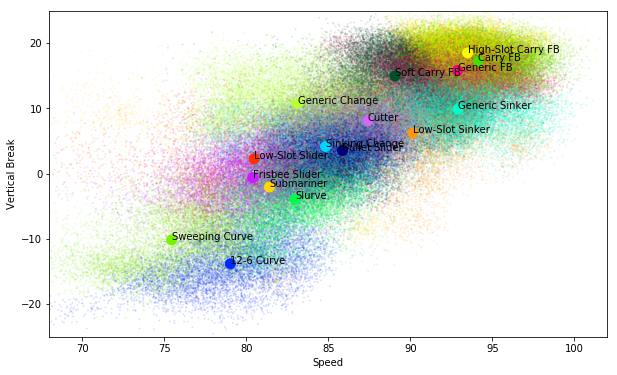

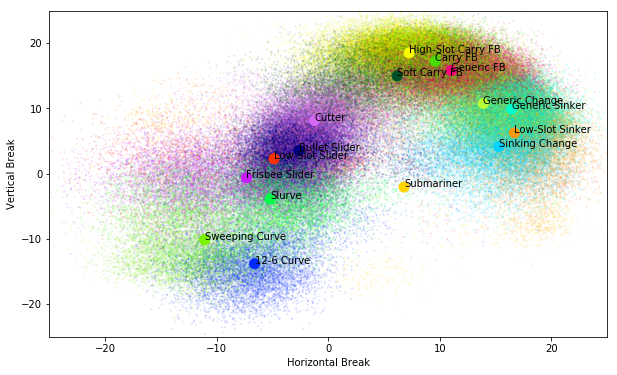

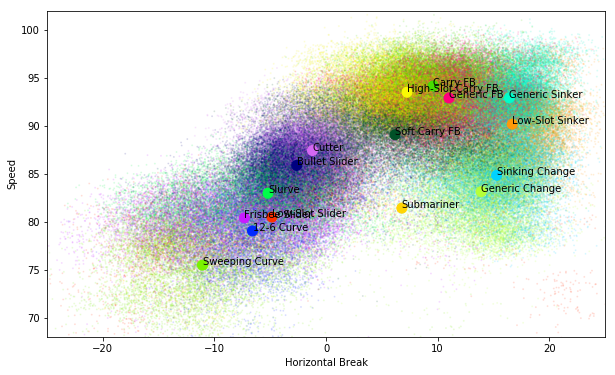

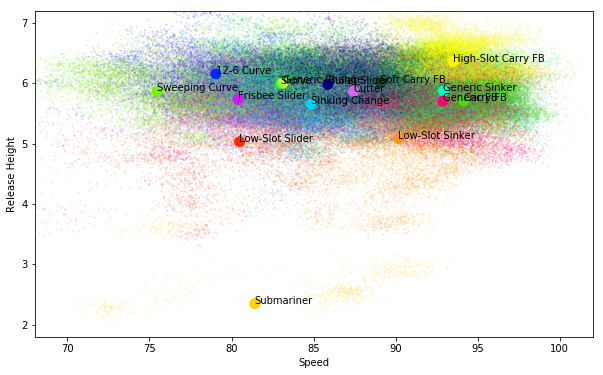

In [7]:
cc['cluster_type'] = ['Bullet Slider', 'Soft Carry FB', '12-6 Curve', 'Sinking Change', 'Generic Sinker', 'Slurve', 'Carry FB', 
                      'Sweeping Curve', 'Generic Change', 'High-Slot Carry FB', 'Submariner', 'Low-Slot Sinker', 
                      'Low-Slot Slider', 'Generic FB', 'Frisbee Slider', 'Cutter']

dp = df.sample(frac=1)

dp = cc.reset_index()[['index', 'cluster_type']].merge(dp, left_on='index', right_on='cluster').drop(columns='index')

dp = dp.sample(frac=1)

for col in predictors:
    dp[col] = dp[col]/f[col]*stds[col]+means[col]

dp['ax'] = -6*dp.ax*((60.5-6)/dp.release_speed)**2
dp['az'] = 6*dp.az*((60.5-6)/dp.release_speed)**2
dp['release_speed'] *= 0.681818

plt.figure(figsize=(10,6))
plt.scatter(dp.release_speed, dp.az, c=dp.cluster, cmap='gist_ncar', s=1, alpha=0.1, vmin=0, vmax=17)
plt.scatter(cc.release_speed, cc.az, c=cc.index, cmap='gist_ncar', s=100, alpha=1, vmin=0, vmax=17)
for index, row in cc.iterrows():
    plt.text(row.release_speed, row.az, row.cluster_type)
plt.xlabel('Speed')
plt.ylabel('Vertical Break')
plt.xlim(68,102)
plt.ylim(-25,25)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(dp.ax, dp.az, c=dp.cluster, cmap='gist_ncar', s=1, alpha=0.1, vmin=0, vmax=17)
plt.scatter(cc.ax, cc.az, c=cc.index, cmap='gist_ncar', s=100, alpha=1, vmin=0, vmax=17)
for index, row in cc.iterrows():
    plt.text(row.ax, row.az, row.cluster_type)
plt.xlabel('Horizontal Break')
plt.ylabel('Vertical Break')
plt.ylim(-25,25)
plt.xlim(-25,25)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(dp.ax, dp.release_speed, c=dp.cluster, cmap='gist_ncar', s=1, alpha=0.1, vmin=0, vmax=17)
plt.scatter(cc.ax, cc.release_speed, c=cc.index, cmap='gist_ncar', s=100, alpha=1, vmin=0, vmax=17)
for index, row in cc.iterrows():
    plt.text(row.ax, row.release_speed, row.cluster_type)
plt.xlabel('Horizontal Break')
plt.ylabel('Speed')
plt.xlim(-25,25)
plt.ylim(68,102)
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(dp.release_speed, dp.release_pos_z, c=dp.cluster, cmap='gist_ncar', s=1, alpha=0.1, vmin=0, vmax=17)
plt.scatter(cc.release_speed, cc.release_pos_z, c=cc.index, cmap='gist_ncar', s=100, alpha=1, vmin=0, vmax=17)
for index, row in cc.iterrows():
    plt.text(row.release_speed, row.release_pos_z, row.cluster_type)
plt.xlabel('Speed')
plt.ylabel('Release Height')
plt.xlim(68, 102)
plt.ylim(1.8,7.2)
plt.show()

### Generating count and location distributions
Don't the clusters look neat! Now it's time to use them to generate the distributions, separately for each platoon matchup. While its simple enough to count up how often each pitch cluster is used in each count, the location distributions are a little more complicated. While it would be nice to generate a separate location distribution for each count, given how infrequently some pitches occur in certain situations (not a ton of 3-0 L vs L Frisbee Sliders), it makes more sense to group together counts where the pitcher is likely to attack the hitter similarly.

Basically, there are 3 situations where a pitcher's approach is likely to change
1. First Pitch: Swing rates are much lower on the first pitch, which makes throwing a strike more valuable.
2. Behind: When there are at least two more balls than strikes, typically the pitcher is trying to get the ball over the plate.
3. Put Away: Because fouls are treated differently in two strike counts, pitching strategy dramatically changes to induce more swing and miss, especially in counts where a ball won't result in a walk and the hitter must defend the plate.

All other counts are simply considered "Even". 

In [8]:
df = cc.reset_index()[['index', 'cluster_type']].merge(df, left_on='index', right_on='cluster').drop(columns='index')

df = df[['player_name', 'pitcher', 'stand', 'p_throws', 'pitch_type', 'cluster_type', 'cluster', 'balls', 'strikes', 
         'release_pos_x', 'release_pos_z', 'release_speed', 'release_speed_fa', 'ax', 'ax_fa', 'az', 'az_fa', 'plate_dist', 
         'plate_x', 'plate_z', 'pitch', 'swing', 'swstr', 'contact', 'foul', 'inplay', 'noswing', 'callstr', 'ball', 'woba']
       ].reset_index(drop=True).copy()

cbs = df[['balls', 'strikes', 'cluster', 'pitcher']].groupby(by=['cluster', 'balls', 'strikes']).count().reset_index()
c = df[['cluster', 'pitcher']].groupby(by=['cluster']).count().reset_index()
cbs = cbs.merge(c, on='cluster')
cbs['pitcher_x'] /= cbs.pitcher_y
cbs = cbs.drop(columns = 'pitcher_y')
cbs.columns = ['cluster', 'balls', 'strikes', 'pct']

df['count_cat'] = np.where((df.strikes + df.balls == 0) , 'First',
                          np.where(df.balls - df.strikes >= 2, 'Behind',
                                  np.where((df.strikes == 2) & (df.balls < 3), 'PutAway', 'Even')))

To calculate the location distribution, I use Kernel Density Estimation, with a Gaussian Kernel and a bandwidth set using a rule of thumb involving the standard deviation and sample size. The resulting log probabilities are evaluated on a grid from -3 to +3 ft horizontally from the center of the plate and -1 to +5 ft above the ground with points spaced 0.2 feet (2.4 in) apart. The bandwidth cannot fall below this grid spacing, no matter how large the sample.

In [9]:
x = np.linspace(-3,3,31)
z = np.linspace(-1,5,31)

grid = np.array(np.meshgrid(x, z)).T.reshape(-1,2)

def kde_cluster(d):
    std = 0.9*np.std(d.plate_x, ddof=1)/2+np.std(d.plate_z, ddof=1)/2
    if len(d) < 64:
        std = 0.9
    kde = KernelDensity(bandwidth = max(0.2, std*len(d)**-(1/6)))
    kde.fit(d[['plate_x', 'plate_z']])
    
    return kde.score_samples(grid)

cp = df.groupby(by=['cluster', 'cluster_type', 'stand', 'p_throws', 'count_cat']).apply(kde_cluster)

cp = cp.reset_index()

### Visualizing the Location distributions

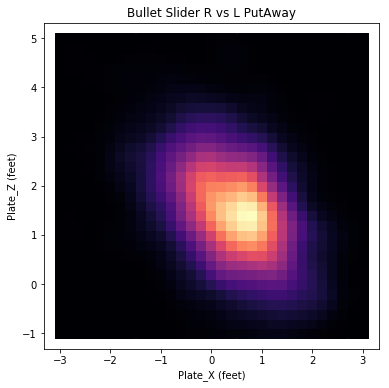

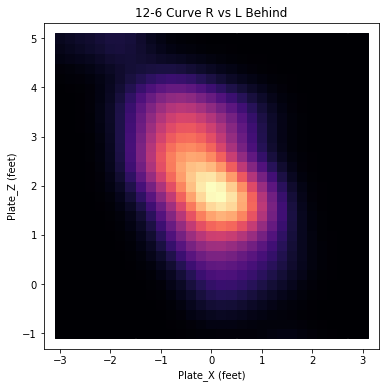

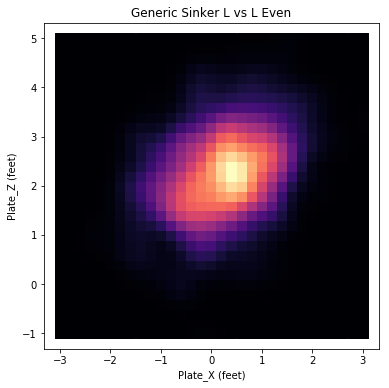

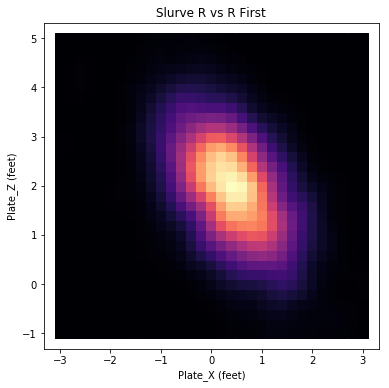

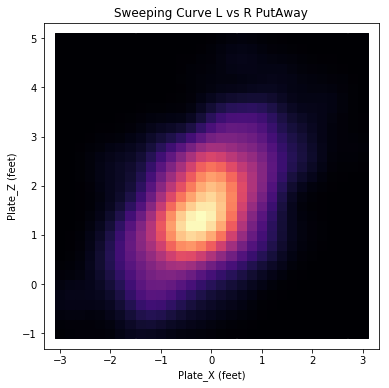

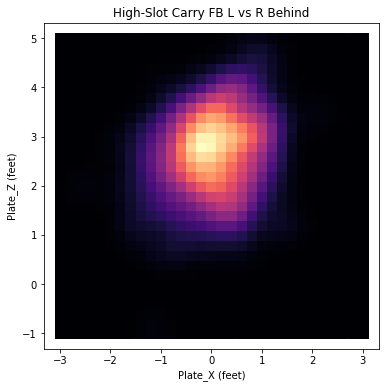

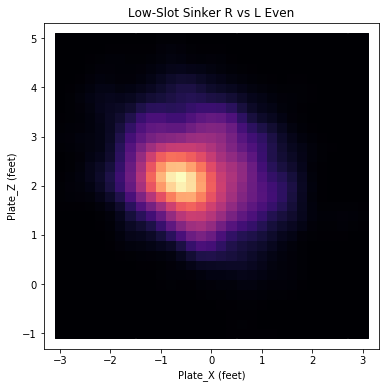

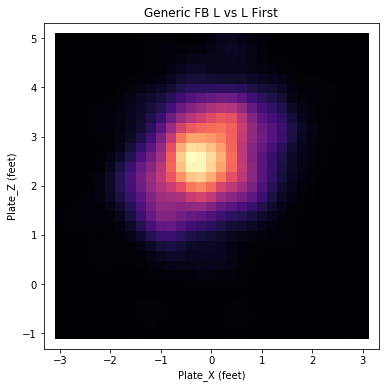

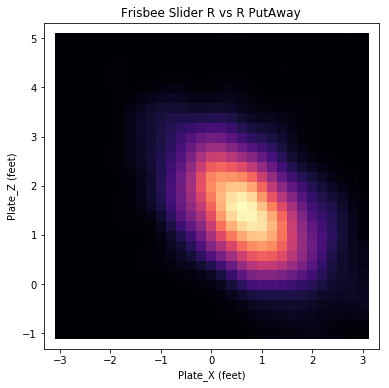

In [10]:
for i in range(len(cp)):
    if i % 29 == 7:
        plt.figure(figsize=(6,6))
        plt.scatter(grid[:,0], grid[:,1], c=np.exp(cp.iloc[i][0]), s=100, cmap='magma', marker='s')
        plt.title(f'{cp.iloc[i].cluster_type} {cp.iloc[i].p_throws} vs {cp.iloc[i].stand} {cp.iloc[i].count_cat}')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

### Building the Pitch Models
The structure of the pitch model is a series of 5 XGBoosts: 4 binary classifiers and one regression. The 4 binary classifiers from a tree that classifies the result of each pitch.

                    Pitch
                 /         \
           Swing             No Swing
         /       \          /        \
       Miss     Contact    Ball     Strike
               /       \
             Foul     In Play
             
So the 4 classifiers are `p(Swing|Pitch)`, `p(Contact|Swing)`, `p(Strike|No Swing)`, and `p(In Play|Contact)`. The conditional probabilities can be multiplied together to calculate the probability of any indiviudal pitch outcome.
             
The regression XGBoost predicts the xwOBAcon (as determined by Baseball Savant) for each pitch that resulted in a ball in play.

A few more things:

* The features used in these models are the same "stuff" features as the previous models, plus the count and the x- and z- coordinates of the ball when it reaches the plate.

* The models for each platoon are separate, but I still want them to share hyperparameters to keep a consistent prediction range for similar pitches in different platoons. So although I tuned the depth, child weight, and gamma for each platoon separately, I kept the set that was closest to the median between the four platoons, breaking ties in favor of right-handed matchups since they occur more often.

* Also, for reasons that will soon be apparent, I am going to focus my analysis for now on a set of 10 pitchers, who all just happen to play for the Dodgers. To ensure that the model predictions are out-of-sample, I removed them from the training set.

In [11]:
predictors = ['release_speed', 'release_speed_fa', 'release_pos_x', 'release_pos_z', 'ax', 'az', 'ax_fa', 'az_fa',
              'balls', 'strikes', 'plate_x', 'plate_z', 'plate_dist']

df = df.dropna(subset=predictors).copy().reset_index(drop=True)

df['xBall'] = 0
df['xCallStr'] = 0
df['xSwStr'] = 0
df['xFoul'] = 0
df['xInPlay'] = 0
df['xwOBAcon'] = 0
df['xwOBAdiff'] = 0

dodgers_pitchers = ['Clayton Kershaw', 'Walker Buehler', 'Dustin May', 'Tony Gonsolin', 'Julio Urias',
                    'Kenley Jansen', 'Brusdar Graterol', 'Joe Kelly', 'Victor Gonzales', 'Dylan Floro']

dd = df.loc[df.player_name.isin(dodgers_pitchers)].copy().reset_index(drop=True)
df = df.loc[~df.player_name.isin(dodgers_pitchers)].copy().reset_index(drop=True)

In [12]:
for pair in [('swing', 'pitch')]:#, ('contact', 'swing'), ('inplay', 'contact'), ('callstr', 'noswing')]:
    for bats in ['L', 'R']:
        for throws in ['L', 'R']:
    
            target = pair[0]

            d = df.loc[(df[pair[1]] == 1) & (df.stand == bats) & (df.p_throws == throws)]

            xgb_temp = XGBClassifier(
             learning_rate = 0.1,
             n_estimators=110,
             max_depth=7,
             min_child_weight=128,
             gamma=0.5,
             subsample=1,
             colsample_bytree=1,
             reg_alpha=0.5,
             reg_lambda=0.2,
             objective= 'binary:logistic',
             nthread=10,
             scale_pos_weight=1,
             seed=42)
            
            param_grid = {
            'min_child_weight': [16, 32, 64], 'gamma': [0.2, 0.5, 1], 'max_depth':[5,6,7]
            }

            clf = GridSearchCV(xgb_temp, param_grid, scoring='neg_log_loss', cv=5, 
                           n_jobs=10, return_train_score = True, verbose = 0)

            clf.fit(d[predictors], d[target])

            print(pair, bats, throws, clf.best_params_)
            

('swing', 'pitch') L L {'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 16}
('swing', 'pitch') L R {'gamma': 0.2, 'max_depth': 7, 'min_child_weight': 64}
('swing', 'pitch') R L {'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 32}
('swing', 'pitch') R R {'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 64}


In [13]:
params = {}

params[('swing', 'pitch')] = [6, 32, 0.5]
params[('contact', 'swing')] = [5, 32, 5]
params[('inplay', 'contact')] = [5, 128, 5]
params[('callstr', 'noswing')] = [5, 4, 1]

Using the optimal hyperparameters found through a grid search, next the final binary classification models are fit.

In [14]:
models = {}

for pair in [('swing', 'pitch'), ('contact', 'swing'), ('inplay', 'contact'), ('callstr', 'noswing')]:
    for bats in ['L', 'R']:
        for throws in ['L', 'R']:
    
            target = pair[0]

            d = df.loc[(df[pair[1]] == 1) & (df.stand == bats) & (df.p_throws == throws)]

            models[(pair[0], bats, throws)] = XGBClassifier(
             learning_rate = 0.1,
             n_estimators=110,
             max_depth=params[pair][0],
             min_child_weight=params[pair][1],
             gamma=params[pair][2],
             subsample=1,
             colsample_bytree=1,
             reg_alpha=0.5,
             reg_lambda=0.2,
             objective= 'binary:logistic',
             nthread=10,
             scale_pos_weight=1,
             seed=42)

            models[(pair[0], bats, throws)].fit(d[predictors], d[target])

Perform the same hyperparameter grid search for the wOBAcon regression XGBoost.

In [15]:
for bats in ['L', 'R']:
    for throws in ['L', 'R']:

        target = 'woba'

        d = df.loc[(df.inplay == 1) & (df.stand == bats) & (df.p_throws == throws)].copy()
        
        d['woba'] = d.woba.fillna(np.mean(d.woba))

        xgb_temp = XGBRegressor(
         learning_rate = 0.1,
         n_estimators=110,
         max_depth=6,
         min_child_weight=256,
         gamma=1,
         subsample=1,
         colsample_bytree=1,
         reg_alpha=0.5,
         reg_lambda=0.2,
         objective= 'reg:squarederror',
         nthread=1,
         scale_pos_weight=1,
         seed=27)

        param_grid = {
            'min_child_weight': [128, 256, 512], 'gamma': [0.5, 1, 2], 'max_depth':[5, 6, 7]
        }

        clf = GridSearchCV(xgb_temp, param_grid, scoring='neg_mean_squared_error', cv=5, 
                           n_jobs=10, return_train_score = True, verbose = 0)

        clf.fit(d[predictors], d[target])
        
        print('woba', bats, throws, clf.best_params_)

woba L L {'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 256}
woba L R {'gamma': 1, 'max_depth': 5, 'min_child_weight': 512}
woba R L {'gamma': 1, 'max_depth': 6, 'min_child_weight': 128}
woba R R {'gamma': 1, 'max_depth': 7, 'min_child_weight': 512}


And fit the final xwOBAcon models.

In [16]:
for bats in ['L', 'R']:
    for throws in ['L', 'R']:

        target = 'woba'

        d = df.loc[(df.inplay == 1) & (df.stand == bats) & (df.p_throws == throws)].copy()
        
        d['woba'] = d.woba.fillna(np.mean(d.woba))

        models[('woba', bats, throws)] = XGBRegressor(
         learning_rate = 0.1,
         n_estimators=110,
         max_depth=6,
         min_child_weight=256,
         gamma=1,
         subsample=1,
         colsample_bytree=1,
         reg_alpha=0.5,
         reg_lambda=0.2,
         objective= 'reg:squarederror',
         nthread=1,
         scale_pos_weight=1,
         seed=27)

        models[('woba', bats, throws)].fit(d[predictors], d[target])

### Combining the Distributions and Models

The main idea is to take each pitch and assign it a usage distribution over count and location for the cluster of pitches that it belongs to. Each cluster has 4 location distributions, one for first pitch (0-0), one for behind (2-0, 3-1, 3-0), one for put away (0-2, 1-2, 2-2), and a final one for everything else. To generate distributions specific to each of the 12 counts, the location distributions are multiplied by the cluster's usage percent in that count. To get predicted results for a pitch, we take the pitch's stuff and combine it with each combination of location and count and feed that into the pitch models. The results of the pitch models are then weighted by the distribution.

Additionally, we can convert these results into an overall value. If we have an estimate of the average value of being in a count, the value of a ball or strike is the difference between the value of the counts and the value of a ball in play is the difference between its expected value and the value of the count that it occurred in. These values can then be combined with the predicted rates for the corresponding events in each count to produce an overall value. For this project, I used wOBA as this measure of value, since that is how baseball savant reports the expected value of batted balls and it was easier to find the average wOBA of PAs that passed through each count (although it was out-of-date and needed to be updated).

Here the first step is to create the grid of plate locations and counts, as well as the value of balls/strikes/fouls and balls in play in each count.

In [17]:
x = np.linspace(-3,3,31)
z = np.linspace(-1,5,31)
b = [0,1,2,3]
s = [0,1,2]
grid = np.array(np.meshgrid(x, z, b, s)).T.reshape(-1,4)

woba_mat = [
    [.332, .283, .212, .000],
    [.371, .314, .237, .000],
    [.443, .372, .290, .000],
    [.570, .490, .403, .000],
    [.711, .711, .711, .711]
]

woba_mat = np.array(woba_mat) * .320/.332

wOBAball = np.zeros(12)
wOBAstrike = np.zeros(12)
wOBAbaseline = np.zeros(12)
wOBAfoul = np.zeros(12)
for i in range(12):
    wOBAbaseline[i] = woba_mat[i//3][i%3]
    wOBAball[i] = woba_mat[i//3+1][i%3] - wOBAbaseline[i]
    wOBAstrike[i] = woba_mat[i//3][i%3+1] - wOBAbaseline[i]
    if i%3 != 2:
        wOBAfoul[i] = wOBAstrike[i]

In my approach, I am using each pitch twice, once vsR and once vsL, regardless of the handedness of the batter. The idea is that the velocity/break/release are not dependent on the batter's handedness, while the usage in terms of count and location are, but those are being provided to us by the distributions instead.

Since the location distribution grid is 31x31 square and there are 12 counts, we must predict the results of `31x31x12 = 11532` pitches for each pitch that we wish to analyze. Unfortunately, that makes this process slow. Not prohibitively slow, however. I can run all 230k pitches from the 2020 season on my home CPU twice (once vsR and once vsL) in about 1 day. However, this is why for this project I am focusing on just 10 pitchers.

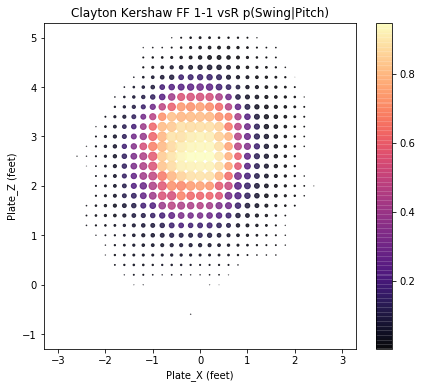

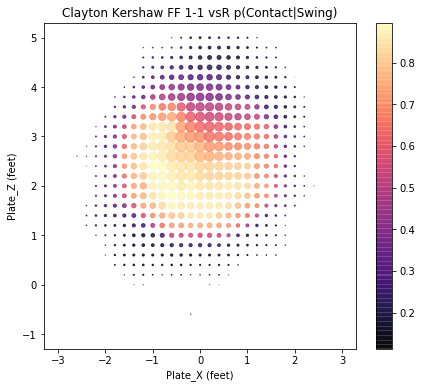

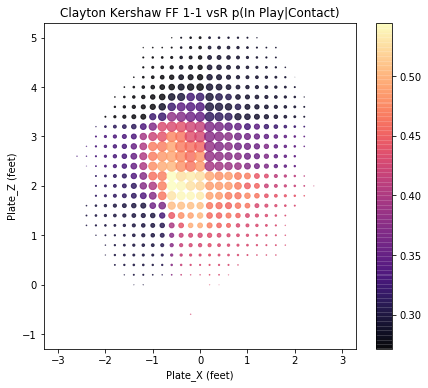

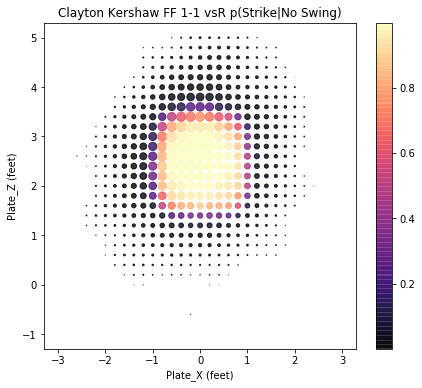

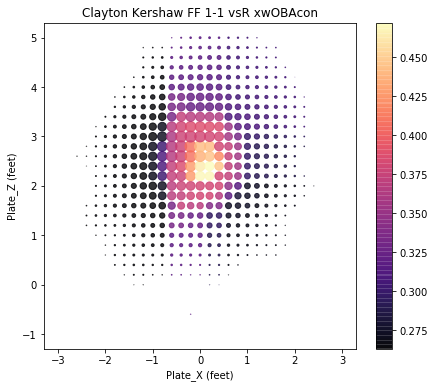

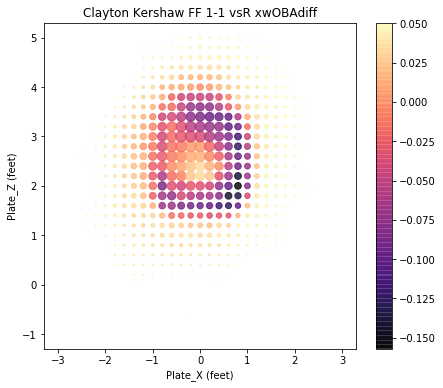

In [18]:
dr = dd.sample(frac=1).copy().reset_index(drop=True)
dr['stand'] = 'R'

for index, row in dr.iterrows():
    p = []
    for i, c in enumerate(['First', 'Even', 'Behind', 'Behind', 'Even', 'Even', 
                           'Even', 'Behind', 'PutAway', 'PutAway', 'PutAway', 'Even']):
        temp = cp.loc[(cp.cluster == row.cluster) & (cp.stand == row.stand) & 
                      (cp.p_throws == row.p_throws) & (cp.count_cat == c)][0].values
        if len(temp) == 0:
            temp = np.zeros(31*31)
        else:
            temp = np.exp(temp[0])
            temp /= sum(temp)
        pct = cbs.loc[(cbs.cluster == row.cluster) & (cbs.balls == i%4) & (cbs.strikes == i//4)].pct.values
        if len(pct) == 0: pct = 0
        else: pct = pct[0]
        temp *= pct
        p.append(np.copy(temp))
    p = np.array(p).reshape(-1)
    d = pd.DataFrame(np.repeat([row[predictors].values], 12*31*31, axis=0)).infer_objects()
    d.columns = predictors
    d['balls'] = grid[:, 2]
    d['strikes'] = grid[:, 3]
    d['plate_x'] = grid[:, 0]
    d['plate_z'] = grid[:, 1]
    d['plate_dist'] = np.sqrt(np.square(d.plate_x) + np.square(d.plate_z-2.5))
    d['swing'] = models[('swing', row.stand, row.p_throws)].predict_proba(d[predictors])[:,1]
    d['contact'] = models[('contact', row.stand, row.p_throws)].predict_proba(d[predictors])[:,1]
    d['inplay'] = models[('inplay', row.stand, row.p_throws)].predict_proba(d[predictors])[:,1]
    d['callstr'] = models[('callstr', row.stand, row.p_throws)].predict_proba(d[predictors])[:,1]
    d['woba'] = models[('woba', 'R', row.p_throws)].predict(d[predictors])
    d['woba_strike'] = np.repeat(wOBAstrike, 31*31)
    d['woba_ball'] = np.repeat(wOBAball, 31*31)
    d['woba_foul'] = np.repeat(wOBAfoul, 31*31)
    d['woba_baseline'] = np.repeat(wOBAbaseline, 31*31)
    if index == 0:
        plt.figure(figsize=(7,6))
        plt.scatter(grid[5*31*31:6*31*31,0], grid[5*31*31:6*31*31,1], s=np.clip(p[5*31*31:6*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.swing.values[5*31*31:6*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 1-1 vsR p(Swing|Pitch)')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

        plt.figure(figsize=(7,6))
        plt.scatter(grid[5*31*31:6*31*31,0], grid[5*31*31:6*31*31,1], s=np.clip(p[5*31*31:6*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.contact.values[5*31*31:6*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 1-1 vsR p(Contact|Swing)')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

        plt.figure(figsize=(7,6))
        plt.scatter(grid[5*31*31:6*31*31,0], grid[5*31*31:6*31*31,1], s=np.clip(p[5*31*31:6*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.inplay.values[5*31*31:6*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 1-1 vsR p(In Play|Contact)')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

        plt.figure(figsize=(7,6))
        plt.scatter(grid[5*31*31:6*31*31,0], grid[5*31*31:6*31*31,1], s=np.clip(p[5*31*31:6*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.callstr.values[5*31*31:6*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 1-1 vsR p(Strike|No Swing)')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

        plt.figure(figsize=(7,6))
        plt.scatter(grid[5*31*31:6*31*31,0], grid[5*31*31:6*31*31,1], s=np.clip(p[5*31*31:6*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.woba.values[5*31*31:6*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 1-1 vsR xwOBAcon')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()
        
        plt.figure(figsize=(7,6))
        plt.scatter(grid[5*31*31:6*31*31,0], grid[5*31*31:6*31*31,1], 
                    s=np.clip(p[5*31*31:6*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=(1-d.swing.values[5*31*31:6*31*31])*(1-d.callstr.values[5*31*31:6*31*31])*d.woba_ball.values[5*31*31:6*31*31]+
                    (1-d.swing.values[5*31*31:6*31*31])*d.callstr.values[5*31*31:6*31*31]*d.woba_strike.values[5*31*31:6*31*31]+
                    d.swing.values[5*31*31:6*31*31]*(1-d.contact.values[5*31*31:6*31*31])*d.woba_strike.values[5*31*31:6*31*31]+
                    d.swing.values[5*31*31:6*31*31]*d.contact.values[5*31*31:6*31*31]*(1-d.inplay.values[5*31*31:6*31*31])*d.woba_foul.values[5*31*31:6*31*31]+
                    d.swing.values[5*31*31:6*31*31]*d.contact.values[5*31*31:6*31*31]*d.inplay.values[5*31*31:6*31*31]*(d.woba.values[5*31*31:6*31*31]-d.woba_baseline.values[5*31*31:6*31*31])
                    , cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 1-1 vsR xwOBAdiff')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()
    
    dr.iloc[index, -7] = np.dot((1-d.swing)*(1-d.callstr), p)
    dr.iloc[index, -6] = np.dot((1-d.swing)*d.callstr, p)
    dr.iloc[index, -5] = np.dot(d.swing*(1-d.contact), p)
    dr.iloc[index, -4] = np.dot(d.swing*d.contact*(1-d.inplay), p)
    dr.iloc[index, -3] = np.dot(d.swing*d.contact*d.inplay, p)
    dr.iloc[index, -2] = np.average(d.woba, weights=d.swing*d.contact*d.inplay)
    dr.iloc[index, -1] = np.dot((1-d.swing)*(1-d.callstr)*d.woba_ball, p)+\
        np.dot((1-d.swing)*d.callstr*d.woba_strike, p)+\
        np.dot(d.swing*(1-d.contact)*d.woba_strike, p)+\
        np.dot(d.swing*d.contact*(1-d.inplay)*d.woba_foul, p)+\
        np.dot(d.swing*d.contact*d.inplay*(d.woba-d.woba_baseline), p)

These plots show the results for a random single pitch evaluated in a 1-1 count against a RHB. They show the conditional probabilities that are output from each model, as well as the final aggregation on a wOBA scale as well. The size of the dots corresponds to the likelihood of the pitch being in that location, while the color corresponds to the model's prediction.

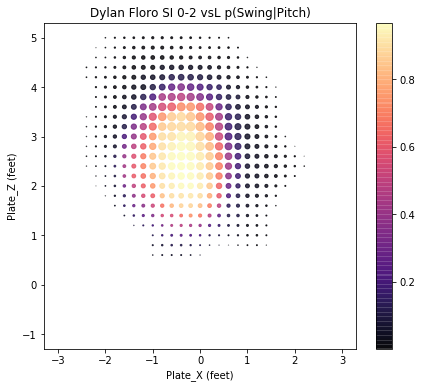

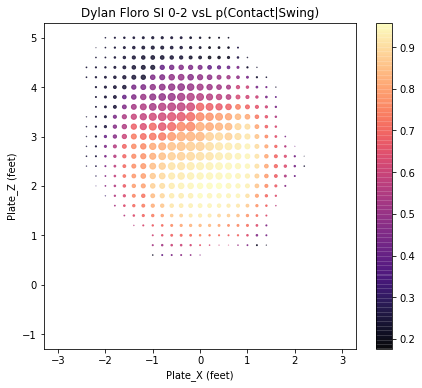

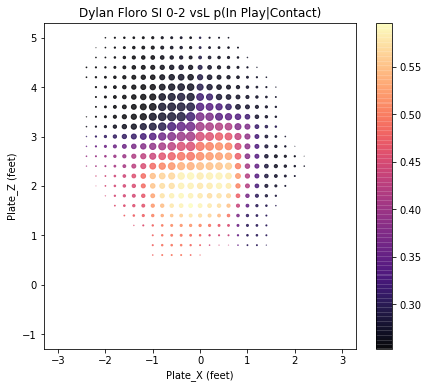

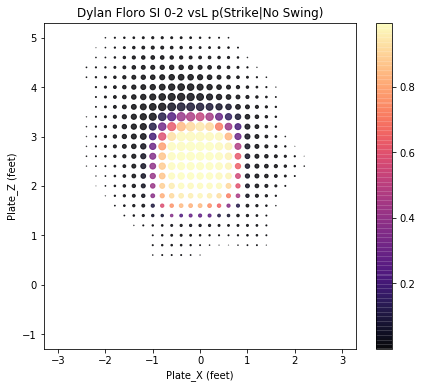

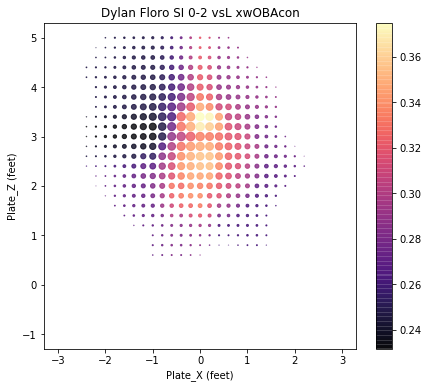

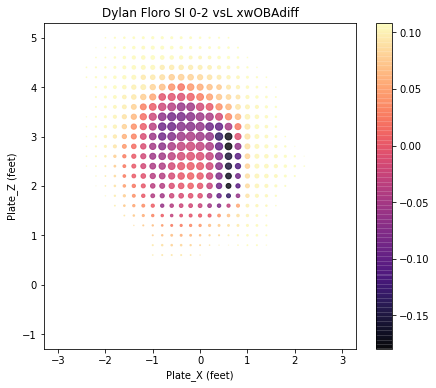

In [19]:
dl = dd.sample(frac=1).copy().reset_index(drop=True)
dl['stand'] = 'L'

for index, row in dl.iterrows():
    p = []
    for i, c in enumerate(['First', 'Even', 'Behind', 'Behind', 'Even', 'Even', 
                           'Even', 'Behind', 'PutAway', 'PutAway', 'PutAway', 'Even']):
        temp = cp.loc[(cp.cluster == row.cluster) & (cp.stand == row.stand) & 
                      (cp.p_throws == row.p_throws) & (cp.count_cat == c)][0].values
        if len(temp) == 0:
            temp = np.zeros(31*31)
        else:
            temp = np.exp(temp[0])
            temp /= sum(temp)
        pct = cbs.loc[(cbs.cluster == row.cluster) & (cbs.balls == i%4) & (cbs.strikes == i//4)].pct.values
        if len(pct) == 0: pct = 0
        else: pct = pct[0]
        temp *= pct
        p.append(np.copy(temp))
    p = np.array(p).reshape(-1)
    d = pd.DataFrame(np.repeat([row[predictors].values], 12*31*31, axis=0)).infer_objects()
    d.columns = predictors
    d['balls'] = grid[:, 2]
    d['strikes'] = grid[:, 3]
    d['plate_x'] = grid[:, 0]
    d['plate_z'] = grid[:, 1]
    d['plate_dist'] = np.sqrt(np.square(d.plate_x) + np.square(d.plate_z-2.5))
    d['swing'] = models[('swing', row.stand, row.p_throws)].predict_proba(d[predictors])[:,1]
    d['contact'] = models[('contact', row.stand, row.p_throws)].predict_proba(d[predictors])[:,1]
    d['inplay'] = models[('inplay', row.stand, row.p_throws)].predict_proba(d[predictors])[:,1]
    d['callstr'] = models[('callstr', row.stand, row.p_throws)].predict_proba(d[predictors])[:,1]
    d['woba'] = models[('woba', 'R', row.p_throws)].predict(d[predictors])
    d['woba_strike'] = np.repeat(wOBAstrike, 31*31)
    d['woba_ball'] = np.repeat(wOBAball, 31*31)
    d['woba_foul'] = np.repeat(wOBAfoul, 31*31)
    d['woba_baseline'] = np.repeat(wOBAbaseline, 31*31)
    if index == 0:
        plt.figure(figsize=(7,6))
        plt.scatter(grid[8*31*31:9*31*31,0], grid[8*31*31:9*31*31,1], 
                    s=np.clip(p[8*31*31:9*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.swing.values[8*31*31:9*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 0-2 vsL p(Swing|Pitch)')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

        plt.figure(figsize=(7,6))
        plt.scatter(grid[8*31*31:9*31*31,0], grid[8*31*31:9*31*31,1], 
                    s=np.clip(p[8*31*31:9*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.contact.values[8*31*31:9*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 0-2 vsL p(Contact|Swing)')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

        plt.figure(figsize=(7,6))
        plt.scatter(grid[8*31*31:9*31*31,0], grid[8*31*31:9*31*31,1], 
                    s=np.clip(p[8*31*31:9*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.inplay.values[8*31*31:9*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 0-2 vsL p(In Play|Contact)')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

        plt.figure(figsize=(7,6))
        plt.scatter(grid[8*31*31:9*31*31,0], grid[8*31*31:9*31*31,1], 
                    s=np.clip(p[8*31*31:9*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.callstr.values[8*31*31:9*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 0-2 vsL p(Strike|No Swing)')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

        plt.figure(figsize=(7,6))
        plt.scatter(grid[8*31*31:9*31*31,0], grid[8*31*31:9*31*31,1], 
                    s=np.clip(p[8*31*31:9*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=d.woba.values[8*31*31:9*31*31], cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 0-2 vsL xwOBAcon')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()
        
        plt.figure(figsize=(7,6))
        plt.scatter(grid[8*31*31:9*31*31,0], grid[8*31*31:9*31*31,1], 
                    s=np.clip(p[8*31*31:9*31*31]-1e-5, 0, 100)*31*31*12*12,
                    c=(1-d.swing.values[8*31*31:9*31*31])*(1-d.callstr.values[8*31*31:9*31*31])*d.woba_ball.values[8*31*31:9*31*31]+
                    (1-d.swing.values[8*31*31:9*31*31])*d.callstr.values[8*31*31:9*31*31]*d.woba_strike.values[8*31*31:9*31*31]+
                    d.swing.values[8*31*31:9*31*31]*(1-d.contact.values[8*31*31:9*31*31])*d.woba_strike.values[8*31*31:9*31*31]+
                    d.swing.values[8*31*31:9*31*31]*d.contact.values[8*31*31:9*31*31]*(1-d.inplay.values[8*31*31:9*31*31])*d.woba_foul.values[8*31*31:9*31*31]+
                    d.swing.values[8*31*31:9*31*31]*d.contact.values[8*31*31:9*31*31]*d.inplay.values[8*31*31:9*31*31]*(d.woba.values[8*31*31:9*31*31]-d.woba_baseline.values[8*31*31:9*31*31])
                    , cmap='magma', marker='o', alpha=0.8)
        plt.colorbar()
        plt.title(f'{row.player_name} {row.pitch_type} 0-2 vsL xwOBAdiff')
        plt.xlabel('Plate_X (feet)')
        plt.ylabel('Plate_Z (feet)')
        plt.show()

    dl.iloc[index, -7] = np.dot((1-d.swing)*(1-d.callstr), p)
    dl.iloc[index, -6] = np.dot((1-d.swing)*d.callstr, p)
    dl.iloc[index, -5] = np.dot(d.swing*(1-d.contact), p)
    dl.iloc[index, -4] = np.dot(d.swing*d.contact*(1-d.inplay), p)
    dl.iloc[index, -3] = np.dot(d.swing*d.contact*d.inplay, p)
    dl.iloc[index, -2] = np.average(d.woba, weights=d.swing*d.contact*d.inplay)
    dl.iloc[index, -1] = np.dot((1-d.swing)*(1-d.callstr)*d.woba_ball, p)+\
        np.dot((1-d.swing)*d.callstr*d.woba_strike, p)+\
        np.dot(d.swing*(1-d.contact)*d.woba_strike, p)+\
        np.dot(d.swing*d.contact*(1-d.inplay)*d.woba_foul, p)+\
        np.dot(d.swing*d.contact*d.inplay*(d.woba-d.woba_baseline), p)

Similarly, these plots show a random pitch evaluated in an 0-2 count against a LHB.

The models are certainly not perfect, and I expect they would benefit thoroughly from the inclusion of more data from seasons prior to 2020. This would allow the XGBoost model to produce a wider range of values without overfitting, especially in the xwOBAcon part of the model. If the xwOBAcon model is too regressed, it won't adequately account for the danger of throwing pitches over the heart of the plate, favoring pitches that are thrown for strikes over pitches that can generate swing and miss.

### Results

First we can take a look at a random selection of pitches and their predicted results. Negative xwOBA diff means a better overall pitch.

In [20]:
dd = pd.concat([dl, dr])

dd[['player_name', 'stand', 'pitch_type', 'cluster_type', 
    'xBall', 'xCallStr', 'xSwStr', 'xFoul', 'xInPlay', 'xwOBAcon', 'xwOBAdiff']]

,player_name,stand,pitch_type,cluster_type,xBall,xCallStr,xSwStr,xFoul,xInPlay,xwOBAcon,xwOBAdiff
0,Dylan Floro,L,SI,Generic FB,0.398706,0.187323,0.076758,0.172834,0.164379,0.320116,-0.004937
1,Dustin May,L,FF,Carry FB,0.362409,0.131986,0.142006,0.201930,0.161668,0.362826,-0.002430
2,Walker Buehler,L,FF,Carry FB,0.378107,0.189688,0.128990,0.191322,0.111893,0.377499,-0.006109
3,Tony Gonsolin,L,FF,High-Slot Carry FB,0.397496,0.172630,0.173439,0.170829,0.085606,0.374281,-0.009488
4,Walker Buehler,L,FF,Carry FB,0.372577,0.166792,0.156139,0.195998,0.108495,0.369027,-0.009092
5,Tony Gonsolin,L,FS,Generic Change,0.404378,0.121079,0.171681,0.129669,0.173193,0.321849,-0.011203
6,Dustin May,L,SI,Generic Sinker,0.389276,0.147651,0.102069,0.205406,0.155598,0.304977,-0.008834
7,Kenley Jansen,L,FC,Cutter,0.397832,0.152767,0.096529,0.200155,0.152718,0.360802,0.001812
8,Julio Urias,L,FF,Carry FB,0.393064,0.203597,0.087812,0.182051,0.133476,0.348072,-0.003012
9,Dylan Floro,L,SI,Generic FB,0.401146,0.182648,0.088365,0.173345,0.154496,0.319460,-0.005637


And next we can aggregate by pitch type and batter handedness.

In [21]:
dd[['player_name', 'stand', 'pitch_type', 'xBall', 'xCallStr', 'xSwStr', 'xFoul', 'xInPlay', 'xwOBAcon', 'xwOBAdiff']
  ].groupby(['player_name', 'stand', 'pitch_type']).mean()

xBall  xCallStr    xSwStr     xFoul  \
player_name      stand pitch_type                                           
Brusdar Graterol L     CH          0.394490  0.150592  0.096561  0.171003   
                       FF          0.383516  0.131911  0.120252  0.208040   
                       SI          0.378387  0.154601  0.089334  0.193137   
                       SL          0.395512  0.163756  0.150462  0.169553   
                 R     CH          0.373795  0.159212  0.133986  0.156213   
                       FF          0.358540  0.162099  0.097198  0.206868   
                       SI          0.353607  0.172343  0.082389  0.195105   
                       SL          0.397036  0.166002  0.201698  0.109416   
Clayton Kershaw  L     CH          0.442495  0.174340  0.086851  0.156863   
                       CU          0.529880  0.199498  0.061204  0.103550   
                       FF          0.391331  0.201517  0.116179  0.171182   
                       SL          0.436645  0.136365  0.125295  0.145990   
                 R     CH          0.436458  0.176006  0.107991  0.131915   
                       CU          0.510381  0.179262  0.084050  0.113079   
                       FF          0.373034  0.174262  0.112790  0.195612   
                       SL          0.407445  0.122071  0.126491  0.181202   
Dustin May       L     CH          0.426783  0.112540  0.146567  0.150240   
                       CU          0.418752  0.200691  0.155706  0.128380   
                       FC          0.388182  0.149832  0.129278  0.187924   
                       FF          0.369367  0.134825  0.148143  0.208493   
                       SI          0.397643  0.148540  0.093064  0.197991   
                 R     CH          0.368139  0.138441  0.193916  0.149838   
                       CU          0.409441  0.190672  0.172281  0.102543   
                       FC          0.405588  0.163771  0.142921  0.143609   
                       FF          0.369094  0.170332  0.121879  0.198957   
                       SI          0.363755  0.169157  0.095025  0.190639   
Dylan Floro      L     CH          0.411306  0.098948  0.137219  0.152371   
                       FF          0.388873  0.170366  0.075352  0.181785   
                       SI          0.395255  0.185598  0.071210  0.179271   
                       SL          0.393028  0.131363  0.116318  0.204538   
                 R     CH          0.385310  0.111529  0.185649  0.161276   
                       FF          0.369108  0.192222  0.072568  0.174891   
                       SI          0.371062  0.217906  0.065100  0.161143   
                       SL          0.443308  0.144748  0.132290  0.129404   
Joe Kelly        L     FF          0.377320  0.139188  0.117877  0.200333   
                       KC          0.402667  0.179596  0.186938  0.122702   
                       SI          0.388088  0.169090  0.094215  0.182338   
                 R     FF          0.370100  0.176152  0.103029  0.183646   
                       KC          0.392426  0.165068  0.198951  0.108144   
                       SI          0.361530  0.186027  0.087010  0.178774   
Julio Urias      L     CH          0.462003  0.112801  0.133686  0.145804   
                       CS          0.494217  0.175788  0.074846  0.124616   
                       CU          0.467491  0.176742  0.119488  0.112782   
                       FF          0.379601  0.187345  0.115964  0.192030   
                       SI          0.407608  0.196629  0.079022  0.178806   
                       SL          0.424669  0.123316  0.173029  0.134162   
                 R     CH          0.395263  0.098894  0.194170  0.132705   
                       CS          0.473347  0.196565  0.082884  0.121473   
                       CU          0.452578  0.176711  0.127718  0.122748   
                       FF          0.383219  0.159754  0.105691  0.201317   
                       SI         

### Potential Uses
While there is plenty of analysis at an individual player level that can be done with this data, I will leave that for another time. It is important to remember that these models do not assume that the pitchers use their pitches optimally. Instead, it assumes they use them how the league uses pitches within the same cluster on average. As a result, it will always be important to compare the results of this model to their actual results with the pitch, and reason about why they might be different. Perhaps the player has especially strong or poor command. Or maybe the player uses the pitch in different situations than most pitchers or locates the pitch differently. Or it could just be that the size of their arsenal makes them more or less predictable to hitters. In any case, overperforming the model likely means the player is doing something well, while underperforming the model likely means the player is doing something poorly.

Additionally, each pitch could be given a grade in each count, based on which results are most valuable in that specific situation. Comparing the value of each pitch in a pitcher's arsenal in each count could help the develop a basic gameplan or rule of thumb about which pitch to use in each count. It could also be used in player evaluation, since having a good pitch for every situation is more important than having multiple average pitches. This may capture some of the benefit of having a larger arsenal.

### Future Improvements
1. The most obvious improvement is training on more data than just 2020. This would facilitate many of the other changes on this list
2. The clustering could be improved in several ways. 
    * With more data, finer clusters could be created while still maintaining the ability to create reasonable location distributions. One potential pitfall is the reintroduction of selection bias if the clusters become too granular, although this could probably be mitigated to some extent by reducing the importance of absolute velocity compared to velocity difference from fastball.
    * Fuzzy clustering could also help better analyze pitches near the border of 2 or more clusters. Instead of assigning each pitch to a single cluster, each pitch is given a probability of belonging to each cluster. The usage distribution then becomes a weighted average over all the clusters.
    * The clustering could also be performed multiple times with different random seeds. Each cluster in each iteration would have its own distribution, and a pitch would have the average distribution of the clusters that it is assigned to.
3. Having separate location distributions for each count, if the data allows.
4. Using Run Value instead of wOBA.
5. Expanding the xwOBAcon model out into its own tree of models. Something like:

            Batted Ball
           /           \
         GB            AIR
        /   \         /   \
       Out  Hit     POP  FB/LD
                         /    \
                        HR    BIP
                              /  \
                            Out   Hit